In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import xarray as xr
import random
%load_ext rpy2.ipython


In [2]:
df = pd.read_csv('../results/model/Nested_model/Reduced_Ne_Pi_recomb.csv')

Filter based on callability and remove X chromosome and adjust for missing coverage by extrapolating

In [3]:
df = df[df['freq_mean']>0.7]
df = df[df['chr']!='chrX']
df['corrected_pi'] = df['PI']*df['freq_mean']

# Standardize and center so priors can be mu = 0 and sigma = 1
# This is done by taking the species specific mean 

In [4]:
grouped_df = df.groupby('full_species')


In [47]:
# Step 2: Calculate Mean and Standard Deviation
means = pd.DataFrame()
means[['mean_pi_species','mean_cm_per_mb_species']] = grouped_df[['corrected_pi', 'cm_per_mb']].mean()
means[['sd_pi_species','sd_cm_per_mb_species']] = grouped_df[['corrected_pi', 'cm_per_mb']].std()
means['primate_mean_ne'] = df['NE_MEDIAN'].mean()
means['primate_sd_ne'] = df['NE_MEDIAN'].std()


means = means[['mean_pi_species','mean_cm_per_mb_species', 'sd_pi_species','sd_cm_per_mb_species', 'primate_mean_ne', 'primate_sd_ne']]

In [48]:
# Merge dataframes on the 'full_species' column
merged_df = pd.merge(df, means, on='full_species')

# Reset the index to remove the default index column
merged_df = merged_df.reset_index(drop=True)


In [64]:
merged_df

,Unnamed: 0,genus,species,full_species,MEAN,MEDIAN,NE_MEAN,NE_MEDIAN,freq_mean,cm_per_mb,...,corrected_pi,mean_pi_species,mean_cm_per_mb_species,sd_pi_species,sd_cm_per_mb_species,primate_mean_ne,primate_sd_ne,z_pi,z_cm_per_mb,z_ne
0,2,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.809708,0.032423,...,0.001466,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355,0.035514,-0.820631,-0.330025
1,3,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.716477,1.734505,...,0.001466,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355,0.036663,0.266051,-0.330025
2,4,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.784308,1.056430,...,0.002012,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355,0.849468,-0.166861,-0.330025
3,5,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.747552,0.420616,...,0.001379,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355,-0.093303,-0.572792,-0.330025
4,6,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.783023,1.470184,...,0.001342,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355,-0.149338,0.097297,-0.330025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940161,5071719,Varecia,variegata,Varecia_variegata,7.275859e-09,7.124613e-09,71894.996141,65217.078027,0.792828,1.517514,...,0.002228,0.001676,1.683315,0.000864,1.679226,70106.64657,64575.160355,0.638573,-0.098736,-0.075719
2940162,5071724,Varecia,variegata,Varecia_variegata,7.275859e-09,7.124613e-09,71894.996141,65217.078027,0.742777,0.186681,...,0.002035,0.001676,1.683315,0.000864,1.679226,70106.64657,64575.160355,0.415710,-0.891264,-0.075719
2940163,5071725,Varecia,variegata,Varecia_variegata,7.275859e-09,7.124613e-09,71894.996141,65217.078027,0.774888,0.255109,...,0.002441,0.001676,1.683315,0.000864,1.679226,70106.64657,64575.160355,0.885051,-0.850514,-0.075719
2940164,5071773,Varecia,variegata,Varecia_variegata,7.275859e-09,7.124613e-09,71894.996141,65217.078027,0.758048,0.140303,...,0.001986,0.001676,1.683315,0.000864,1.679226,70106.64657,64575.160355,0.358877,-0.918883,-0.075719


In [49]:
merged_df['z_pi'] = (merged_df['corrected_pi']-merged_df['mean_pi_species'])/merged_df['sd_pi_species']
merged_df['z_cm_per_mb'] = (merged_df['cm_per_mb']-merged_df['mean_cm_per_mb_species'])/merged_df['sd_cm_per_mb_species']
merged_df['z_ne'] = (merged_df['NE_MEDIAN']-merged_df['primate_mean_ne'])/merged_df['primate_sd_ne']
z_df = merged_df[['full_species','NE_MEDIAN','z_pi', 'z_cm_per_mb', 'z_ne']]

In [50]:
z_df

,full_species,NE_MEDIAN,z_pi,z_cm_per_mb,z_ne
0,Allenopithecus_nigroviridis,48795.239046,0.035514,-0.820631,-0.330025
1,Allenopithecus_nigroviridis,48795.239046,0.036663,0.266051,-0.330025
2,Allenopithecus_nigroviridis,48795.239046,0.849468,-0.166861,-0.330025
3,Allenopithecus_nigroviridis,48795.239046,-0.093303,-0.572792,-0.330025
4,Allenopithecus_nigroviridis,48795.239046,-0.149338,0.097297,-0.330025
...,...,...,...,...,...
2940161,Varecia_variegata,65217.078027,0.638573,-0.098736,-0.075719
2940162,Varecia_variegata,65217.078027,0.415710,-0.891264,-0.075719
2940163,Varecia_variegata,65217.078027,0.885051,-0.850514,-0.075719
2940164,Varecia_variegata,65217.078027,0.358877,-0.918883,-0.075719


In [51]:
unique_Species = z_df['full_species'].unique()
species_lookup = dict(zip(unique_Species, range(len(unique_Species))))
Ne =  (pd.DataFrame([z_df['full_species'], z_df['z_ne']]).transpose()).drop_duplicates()
pi = z_df['z_pi'].values
recombinationrate = z_df['z_cm_per_mb'].values
species = z_df['full_species'].replace(species_lookup).values

PYMC formulation 

Make variables

In [52]:
hierarchical_model = pm.Model(coords = {"Species": unique_Species, 
                                        "obs_id": np.arange(len(recombinationrate))})

In [53]:
with hierarchical_model:
# Data
    recomb = pm.ConstantData('recomb', recombinationrate, dims = 'obs_id')
    pi = pm.ConstantData('pi', pi, dims = 'obs_id')
    sp = pm.ConstantData('sp',species, dims = 'obs_id')
    Ne =  pm.ConstantData('Ne', Ne['z_ne'], dims = 'Species')

# Hyperpriors:
    g0 = pm.Normal("g0", mu=0, sigma=1)
    g1 = pm.Normal("g1", mu=0, sigma=1)
    h0 = pm.Normal("h0", mu=0, sigma=1)
    h1 = pm.Normal("h1", mu=0, sigma=1)

    mu_a = g0+g1*Ne
    mu_b = h0+h1*Ne
    sigma_a = pm.Exponential("sigma_a", 1)
    sigma_b = pm.Exponential("sigma_b", 1)
    if non_centered == True:
    # Varying intercepts:
        a_offset = pm.Normal("a_offset", 0, sigma=1, dims="Species")
        a = pm.Deterministic("a", mu_a + a_offset * sigma_a, dims="Species")
        # Varying slopes:
        b_offset = pm.Normal("b_offset", 0, sigma=1, dims="Species")
        b = pm.Deterministic("b", mu_b + b_offset * sigma_b, dims="Species")
# Expected value per species:
    y = a[sp] + b[sp] * recomb
# Model error
    sigma = pm.Exponential("sigma", 0.01)
    Pi = pm.Normal("Pi", mu=y, sigma=sigma, observed=pi, dims="obs_id")

In [54]:
with hierarchical_model:
    idata = pm.sample_prior_predictive(samples=50)

Sampling: [Pi, a_offset, b_offset, g0, g1, h0, h1, sigma, sigma_a, sigma_b]


<Axes: xlabel='Pi / Pi'>

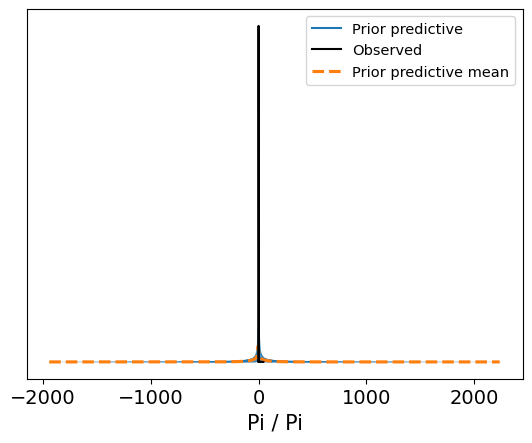

In [55]:
az.plot_ppc(idata, group='prior')

In [13]:
pm.model_to_graphviz(hierarchical_model)

AttributeError: 'InferenceData' object has no attribute 'named_vars'

In [18]:
with hierarchical_model:
    hier_reg_idata = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g0, g1, h0, h1, sigma_a, sigma_b, a, b, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 16182 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 320 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#with hierarchical_model:
#   hier_reg_idata = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True,
#                                 progressbar=True, cores=1, chains=4)

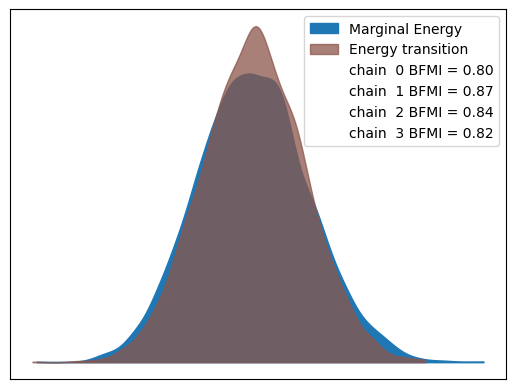

In [12]:
az.plot_energy(hierarchical_model);

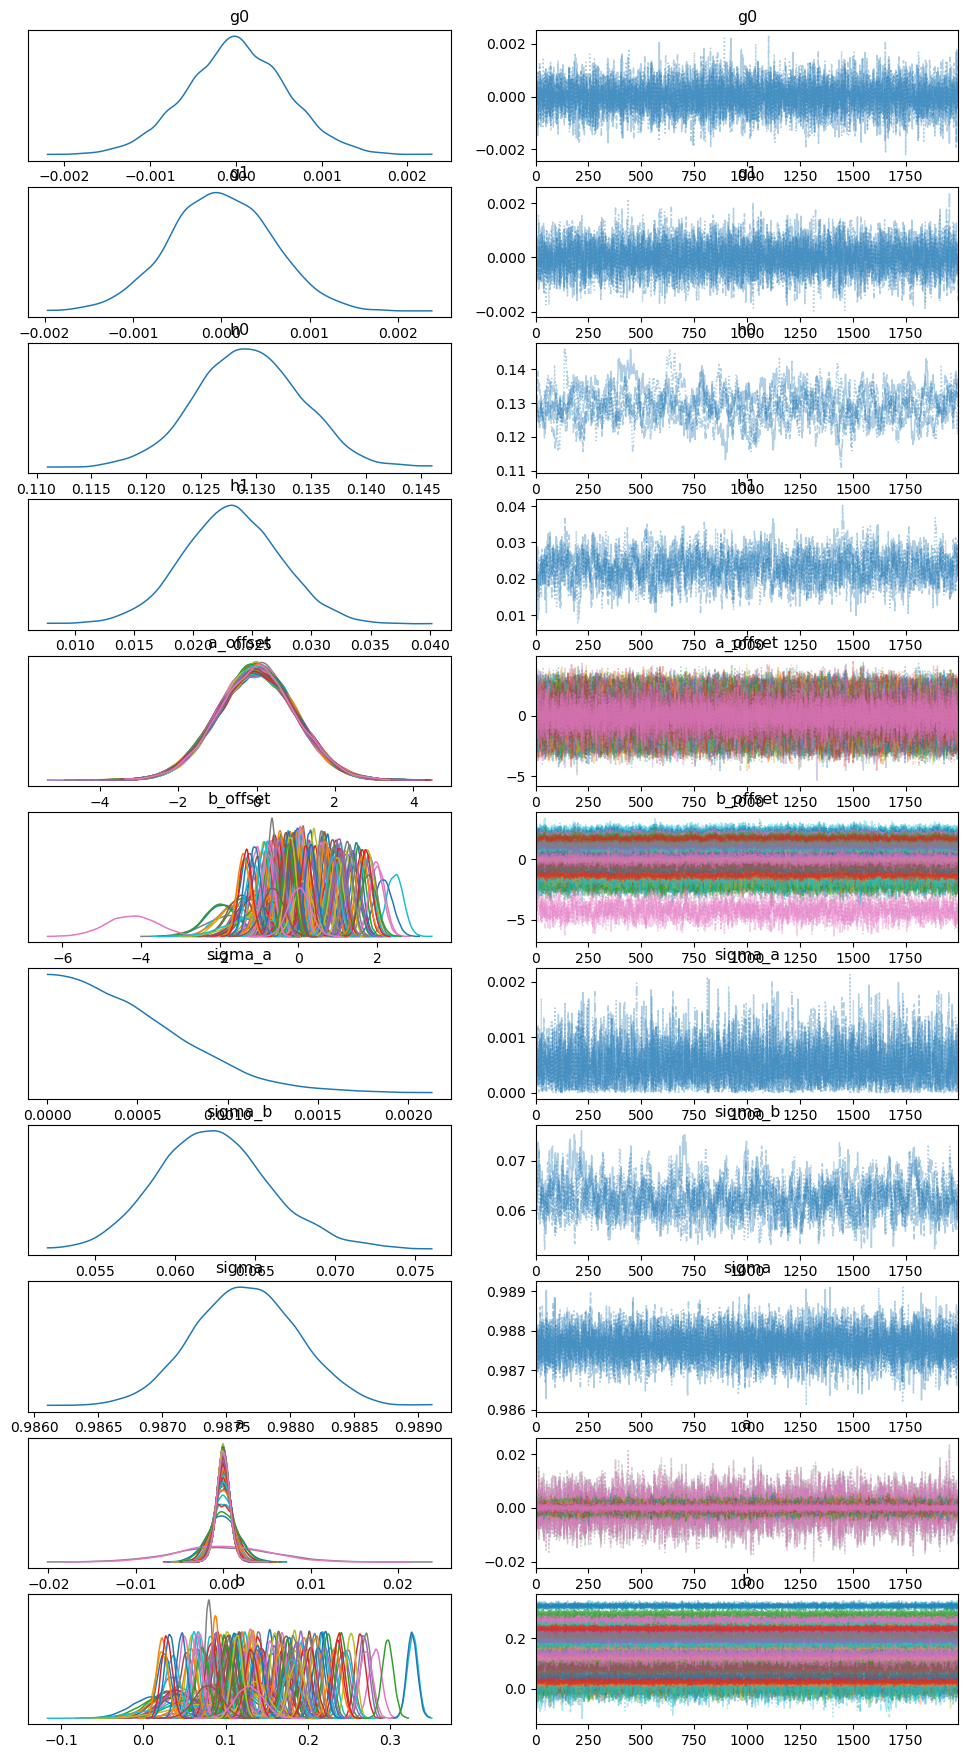

In [8]:
az.plot_trace(hierarchical_model, combined=True);

In [11]:

hierarchical_model = az.from_netcdf('../results/model/Nested_model/hierarchical_model/hierarchical_model_18_12_2023.nc')

In [6]:
g0 = hierarchical_model.posterior.g0.to_dataframe()
g0.to_csv("../results/model/Nested_model/hierarchical_model/g0_18_12_2023", sep="\t")
g1 = hierarchical_model.posterior.g1.to_dataframe()
g1.to_csv("../results/model/Nested_model/hierarchical_model/g1_18_12_2023", sep="\t")
h0 = hierarchical_model.posterior.h0.to_dataframe()
h0.to_csv("../results/model/Nested_model/hierarchical_model/h0_18_12_2023", sep="\t")
h1 = hierarchical_model.posterior.h1.to_dataframe()
h1.to_csv("../results/model/Nested_model/hierarchical_model/h1_18_12_2023", sep="\t")
sigma_a = hierarchical_model.posterior.sigma_a.to_dataframe()
sigma_a.to_csv("../results/model/Nested_model/hierarchical_model/sigma_a_18_12_2023", sep="\t")
sigma_b = hierarchical_model.posterior.sigma_b.to_dataframe()
sigma_b.to_csv("../results/model/Nested_model/hierarchical_model/sigma_b_18_12_2023", sep="\t")
a = hierarchical_model.posterior.a.to_dataframe()
a.to_csv("../results/model/Nested_model/hierarchical_model/a_18_12_2023", sep="\t")
b = hierarchical_model.posterior.b.to_dataframe()
b.to_csv("../results/model/Nested_model/hierarchical_model/b_18_12_2023", sep="\t")
sgm = hierarchical_model.posterior.sigma.to_dataframe()
sgm.to_csv("../results/model/Nested_model/hierarchical_model/sigma_model_18_12_2023", sep="\t")

# Log scaled Ne model

In [5]:
#TAKING THE LOG TO BOTH NE AND CM_PER_MB
means_log = pd.DataFrame()
# Step 2: Calculate Mean and Standard Deviation
means_log['mean_pi_species'] = grouped_df['corrected_pi'].mean()
means_log['mean_cm_per_mb_species'] = np.log10(grouped_df['cm_per_mb'].mean())
means_log['sd_pi_species'] = grouped_df['corrected_pi'].std()
means_log['sd_cm_per_mb_species'] = np.log10(grouped_df['cm_per_mb'].std())
means_log['primate_mean_ne'] = np.log10(df['NE_MEDIAN'].mean())
means_log['primate_sd_ne'] = np.log10(df['NE_MEDIAN'].std())


means_log = means_log[['mean_pi_species','mean_cm_per_mb_species', 'sd_pi_species','sd_cm_per_mb_species', 'primate_mean_ne', 'primate_sd_ne']]

In [95]:
# Merge dataframes on the 'full_species' column
merged_log_df = pd.merge(df, means_log, on='full_species')

# Reset the index to remove the default index column
merged_log_df = merged_log_df.reset_index(drop=True).dropna()
#remove real zeros
merged_log_df = merged_log_df[merged_log_df['cm_per_mb']!=0]


In [96]:
merged_log_df['z_pi'] = (merged_log_df['corrected_pi']-merged_log_df['mean_pi_species'])/merged_log_df['sd_pi_species']
merged_log_df['z_cm_per_mb'] = (np.log10(merged_log_df['cm_per_mb'])-merged_log_df['mean_cm_per_mb_species'])/merged_log_df['sd_cm_per_mb_species']
merged_log_df['z_ne'] = (np.log10(merged_log_df['NE_MEDIAN'])-merged_log_df['primate_mean_ne'])/merged_log_df['primate_sd_ne']
z_log_df = merged_log_df[['full_species','NE_MEDIAN','z_pi', 'z_cm_per_mb', 'z_ne']]

In [99]:
z_log_df

,full_species,NE_MEDIAN,z_pi,z_cm_per_mb,z_ne
0,Allenopithecus_nigroviridis,48795.239046,0.035514,-8.256388,-0.032719
1,Allenopithecus_nigroviridis,48795.239046,0.036663,0.612334,-0.032719
2,Allenopithecus_nigroviridis,48795.239046,0.849468,-0.492639,-0.032719
3,Allenopithecus_nigroviridis,48795.239046,-0.093303,-2.544971,-0.032719
4,Allenopithecus_nigroviridis,48795.239046,-0.149338,0.243879,-0.032719
...,...,...,...,...,...
2940161,Varecia_variegata,65217.078027,0.638573,-0.200048,-0.006528
2940162,Varecia_variegata,65217.078027,0.415710,-4.242678,-0.006528
2940163,Varecia_variegata,65217.078027,0.885051,-3.640185,-0.006528
2940164,Varecia_variegata,65217.078027,0.358877,-4.793674,-0.006528


In [100]:
unique_Species_log = z_log_df['full_species'].unique()
species_lookup_log = dict(zip(unique_Species_log, range(len(unique_Species_log))))
Ne_log =  (pd.DataFrame([z_log_df['full_species'], z_log_df['z_ne']]).transpose()).drop_duplicates()
pi_log = z_log_df['z_pi'].values
recombinationrate_log = z_log_df['z_cm_per_mb'].values
species_log = z_log_df['full_species'].replace(species_lookup_log).values


In [101]:
Ne_log 

,full_species,z_ne
0,Allenopithecus_nigroviridis,-0.032719
23342,Allochrocebus_lhoesti,0.015532
46984,Allochrocebus_preussi,0.024187
70575,Allochrocebus_solatus,0.033431
93138,Alouatta_belzebul,-0.022621
...,...,...
2872164,Trachypithecus_melamera,-0.061733
2889185,Trachypithecus_phayrei,-0.107995
2911924,Trachypithecus_pileatus,-0.05385
2933570,Varecia_rubra,-0.045717


In [102]:
hierarchical_log_scaled_ne_cmpermb_model = pm.Model(coords = {"Species": unique_Species_log, 
                                        "obs_id": np.arange(len(recombinationrate_log))})
non_centered = True

In [103]:
with hierarchical_log_scaled_ne_cmpermb_model:
# Data
    recomb = pm.ConstantData('recomb', recombinationrate_log, dims = 'obs_id')
    pi = pm.ConstantData('pi', pi_log, dims = 'obs_id')
    sp = pm.ConstantData('sp',species_log, dims = 'obs_id')
    Ne =  pm.ConstantData('Ne', Ne_log['z_ne'], dims = 'Species')

#Hyperpriors:
    g0 = pm.Normal("g0", mu=0, sigma=1)
    g1 = pm.Normal("g1", mu=0, sigma=1)
    h0 = pm.Normal("h0", mu=0, sigma=1)
    h1 = pm.Normal("h1", mu=0, sigma=1)

    mu_a = g0+g1*Ne
    mu_b = h0+h1*Ne
    sigma_a = pm.Exponential("sigma_a", 1)
    sigma_b = pm.Exponential("sigma_b", 1)
    if non_centered == True:
    # Varying intercepts:
        a_offset = pm.Normal("a_offset", 0, sigma=1, dims="Species")
        a = pm.Deterministic("a", mu_a + a_offset * sigma_a, dims="Species")
        # Varying slopes:
        b_offset = pm.Normal("b_offset", 0, sigma=1, dims="Species")
        b = pm.Deterministic("b", mu_b + b_offset * sigma_b, dims="Species")
# Expected value per species:
    y = a[sp] + b[sp] * recomb
# Model error
    sigma = pm.Exponential("sigma", 0.01)
    Pi = pm.Normal("Pi", mu=y, sigma=sigma, observed=pi, dims="obs_id")


In [104]:
with hierarchical_log_scaled_ne_cmpermb_model:
    idata = pm.sample_prior_predictive(samples=50)

Sampling: [Pi, a_offset, b_offset, g0, g1, h0, h1, sigma, sigma_a, sigma_b]


<Axes: xlabel='Pi / Pi'>

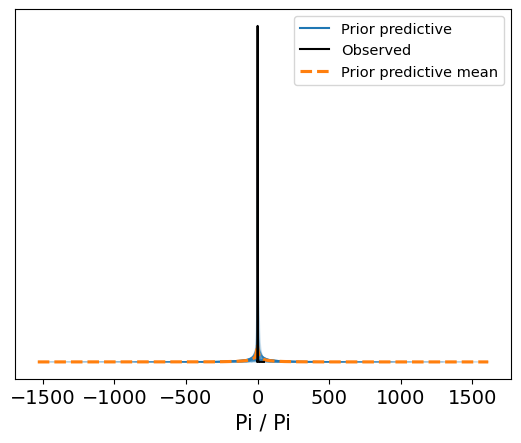

In [105]:
az.plot_ppc(idata, group='prior')

In [106]:
with hierarchical_log_scaled_ne_cmpermb_model:
    hierarchical_log_scaled_ne_cmpermb_model_idata = pm.sample(1000, target_accept=0.95, return_inferencedata=True,
                                 progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g0, g1, h0, h1, sigma_a, sigma_b, a_offset, b_offset, sigma]


ValueError: Not enough samples to build a trace.

trace_file = "{}/{}_{}_{}_model.nc".format(path_mod, anc, sta, modeltype)
if os.path.exists(trace_file):
    print("Trace exists, loading...")
    trace_model_with_apha = az.from_netcdf(trace_file)
else:
    with model_with_apha:
        print("Trace does not exist, sampling...")
        trace_model_with_apha = pm.sample(return_inferencedata=True)
        trace_model_with_apha.to_netcdf(trace_file)

In [ ]:
az.plot_energy(hierarchical_log_scaled_ne_cmpermb_model_idata);

In [ ]:
az.plot_trace(hierarchical_log_scaled_ne_cmpermb_model, combined=True);

In [ ]:
g0 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.g0.to_dataframe()
g0.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/g0_15_12", sep="\t")
g1 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.g1.to_dataframe()
g1.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/g1_15_12_2023", sep="\t")
h0 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.h0.to_dataframe()
h0.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h0_15_12_2023", sep="\t")
h1 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.h1.to_dataframe()
h1.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h1_15_12_2023", sep="\t")
sigma_a = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.sigma_a.to_dataframe()
sigma_a.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_a_15_12_2023", sep="\t")
sigma_b = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.sigma_b.to_dataframe()
sigma_b.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_b_15_12_2023", sep="\t")
a = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.a.to_dataframe()
a.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/a_15_12_2023", sep="\t")
b = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.b.to_dataframe()
b.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/b_15_12_2023", sep="\t")
sgm = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.sigma.to_dataframe()
sgm.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_model_15_12_2023", sep="\t")
if non_centered is True:
    b_offset = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.b_offset.to_dataframe()
    b_offset.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/b_offset_15_12_2023", sep="\t")
    a_offset = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.a_offset.to_dataframe()
    a_offset.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/a_offset_15_12_2023", sep="\t")
hierarchical_log_scaled_ne_cmpermb_model_idata.to_netdf('../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/hierarchical_log_scaled_ne_cmpermb_model.nc')